# Estimation and Backtesting of VaR and ES

The new FRTB IMA requirements are based on the expected shortfall (ES) risk measure. It replaced value at risk (VaR) measure, previously used in the market risk rule and Basel capital requirements. In the acedemic literature, ES is also called a tail VaR (TVaR) or conditional VaR (CVaR). ES is a more extreme risk measure as it gives an estimate of the extreme expected losses rather than a lower bound of the extreme losses as in the case of VaR. From the mathematical point of view, the most prominent difference between VaR and ES is that ES obeys sub-additivity property and, therefore, is a coherent risk measure. In this project we will generate a few functions that might be usefull in the VaR/ES modeling.

### Financial data pull
- $\textit{pull_stock(tickers)}$ - pulls equity data using yfinance package
- $\textit{pull_econ(series)}$ - pulls economic data using fred package

In this part we will create two functions that will allow user to pull data from Yahoo! Finance and FRED. The user has ability to pick any stock ticker (e.g. TFC, IBM, TSLA, etc.) and/or FRED time series (SP500, FEDFUNDS, T10Y2Y).

https://finance.yahoo.com

https://fred.stlouisfed.org

The FRED pull requires a FRED API key that can be requested here.

https://fred.stlouisfed.org/docs/api/api_key.html



### Financial data simulation 
- $\textit{sim_bm(M,N)}$ - simulates $M$ Brownian motion paths on [0,1] interval with step $\delta t = \frac{1}{N}$
- $\textit{sim_gbm(M,N)}$ - simulates $M$ geometric Brownian motion paths on [0,1] interval with step $\delta t = \frac{1}{N}$

In this part we will simulate a discrete version of the Brownian motion $X_t=t+\frac{1}{2}W_t$ and its geometric counterpart $S_t=e^{t+\frac{1}{2}W_t}$ using Euler discretization scheme on [0,1] interval.

### Generate infrequent time series
- $\textit{infreq(data)}$ - converts original time series returns $(X_t-X_{t-1})$ to $T$-lagged version $\chi_t^T$

$
\chi_t^T=\xi(X_t-X_{t-T})=\xi \sum_{i=t-(T-1)}^t(X_i-X_{i-1})
$

The binomial random variable $\xi \sim B(1,1/T)$ represents an event when the MtM gets updated, this occurs with probability $1/T$. Infrequent mark-to-market time series can be used to demonstrate the overestimation effect discussed in the "Infrequent MtM neither reduces VaR nor backtesting exceptions" paper (to be published in Risk magazine).

### Estimate VaR and ES
- $\textit{es_par(data,$\alpha$)}$ - estimates VaR and ES for a small portfolio of equities using paramatric approach
- $\textit{es_nonpar(data,$\alpha$)}$ - estimates VaR and ES for a small portfolio of equities using non-paramatric approach
- $\textit{es_semipar(data,$\alpha$)}$ - estimates VaR and ES for a small portfolio of equities using semi-paramatric approach

We will compare performance of the parametric, non-parametric, and semi-parametric estimators in terms of variance of the estimators. The semi-parametric estimators were derived in the "On Asymptotic Properties of Value-at-Risk (VaR) and Expected Shortfall (ES) Estimators" work-in-progress paper using the theory of L-estimators.

### Backtest VaR and ES
- $\textit{back_traffic(data,$\alpha)$}$ - backtests ES using trafic light tests
- $\textit{back_ascond(data,$\alpha)$}$ - backtests ES using conditional Acerbi-Szekely test 
- $\textit{back_asuncond(data,$\alpha)$}$ - backtests ES using unconditional Acerbi-Szekely test

The traffic light test was introduced by Moldenhauer and Pitera in "Backtesting expected shortfall: is it really that hard?" It is based on a simple idea that $ES_{\alpha}$ should be comprised on $n(1-\alpha)$ worst P&Ls for $n$ observations. If the number of worst P&Ls required for $ES_{\alpha}$ is significantly larger that $n(1-\alpha)$, then there is an issue with an $ES_{\alpha}$ estimation.

https://arxiv.org/pdf/1709.01337.pdf

Unlike the traffic light test that replicates $ES_{\alpha}$ using actual P&Ls, the AS tests calculate empirical $ES_{act}$ using actual P&Ls and compare it to the estimated one. In their tests they are using conditional and unconditional approaches. In the conditional case, they calculate empirical $ES_{act}$ using a VaR estimate, in the unconditional case, they calculate $ES_{act}$ direclty without using the VaR estimate.

https://www.msci.com/documents/10199/22aa9922-f874-4060-b77a-0f0e267a489b

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import datetime
from scipy.stats import norm
import statistics
from fredapi import Fred

### Financial data pull

In [2]:
def pull_stock(tickers):    
    # Define start and end date
    start_date = datetime.datetime(2000, 1, 1)
    end_date = datetime.datetime(2024, 2, 14)

    # Download stock data using yfinance, sample stock tickers: TFC, BAC, WFC, JPM, CMA
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    # stock_data = yf.download(['TFC', 'BAC'], start=start_date, end=end_date)['Adj Close']
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data = stock_data.dropna()
    
    return stock_data

[*********************100%%**********************]  5 of 5 completed


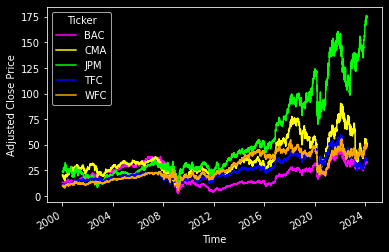

In [3]:
tickers = ['TFC', 'BAC', 'WFC', 'JPM', 'CMA']
stock_data = pull_stock(tickers)

plt.style.use('dark_background')
bright_colors = ['magenta', 'yellow', 'lime', 'blue', 'orange', 'pink', 'cyan']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=bright_colors)

ax = stock_data.plot.line(xlabel="Time", ylabel="Adjusted Close Price")

plt.savefig('stock_hist.png')

plt.show()

In [4]:
def pull_econ(series):
    # Download FRED data using API, sample series names: SP500, FEDFUNDS
    # fred = Fred(api_key='your API key goes here')
    fred = Fred(api_key='90e62454fa7a47ec11613ec9f5ac902a')

    econ_data = fred.get_series(series)
    
    return econ_data

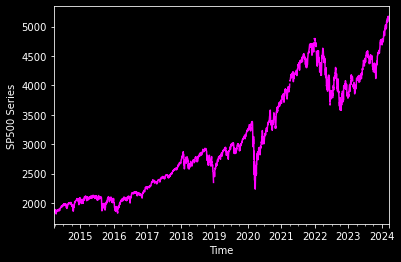

In [5]:
series = 'SP500'
econ_data = pull_econ(series)
ax = econ_data.plot.line(xlabel="Time", ylabel="SP500 Series")

plt.savefig('sp500_hist.png')

plt.show()

### Financial data simulation
Let's start with Brownian motion
$X_t = t +\frac{1}{2}W_t$

In [6]:
def sbm(M,N):
    np.random.seed(100)
    
    # Breaking down [0,1] interval into N steps
    T = 1
    dt = T / N
    t = np.arange(dt, 1 + dt, dt)
    
    # Simulating dW
    dW = np.sqrt(dt) * np.random.randn(M, N)
    W = np.cumsum(dW, axis=1)
    
    # Calculating X_t
    X = np.tile(t, (M, 1)) + 0.5 * W
    
    return (X,t)

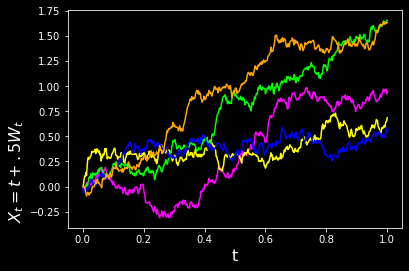

In [7]:
(X,t) = sbm(1000,500)

# Plot 5 individual paths of X_t
for i in range(5):
    plt.plot(np.concatenate(([0], t)), np.concatenate(([0], X[i, :])))
    
plt.xlabel('t', fontsize=16)
plt.ylabel('$X_t=t+.5W_t$', fontsize=16, rotation=90, ha='right')
#plt.grid(True)

plt.savefig('stock_sim_bw.png')

plt.show()

 ## Simulate geometric Brownian motion (gBm)
 $S_t=e^{t+\frac{1}{2}W_t}$ and plot $\ln$ of real stock data

In [8]:
def sgbm(M,N):
    np.random.seed(100)
    
    # Breaking down [0,1] interval into N steps
    T = 1
    dt = T / N
    t = np.arange(dt, 1 + dt, dt)
    
    # Simulating dW
    dW = np.sqrt(dt) * np.random.randn(M, N)
    W = np.cumsum(dW, axis=1)
    
    # Calculating X_t
    S = np.exp(np.tile(t, (M, 1)) + 0.5 * W)
    
    return (S,t)

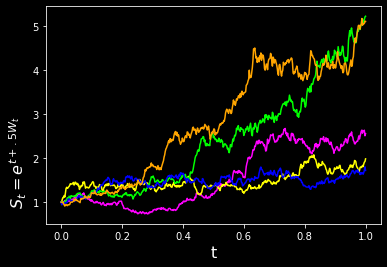

In [9]:
(S,t) = sgbm(1000,500)

# Plot 5 individual paths of X_t
for i in range(5):
    plt.plot(np.concatenate(([0], t)), np.concatenate(([1], S[i, :])))
    
plt.xlabel('t', fontsize=16)
plt.ylabel('$S_t=e^{t+.5W_t}$', fontsize=16, rotation=90, ha='right')
#plt.grid(True)

plt.savefig('stock_sim_gbm.png')

plt.show()

 ### Let's plot $dS_t=dt+\frac{1}{2}dW_t$ and percent changes in stock prices

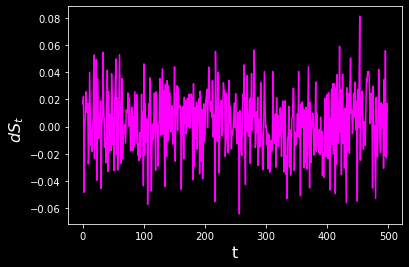

In [10]:
S_delta = np.diff(np.log(S))

# We will plot path #22
plt.plot(S_delta[22, :])

plt.xlabel('t', fontsize=16)
plt.ylabel('$dS_t$', fontsize=16, rotation=90, ha='right')
#plt.grid(True)

plt.show()

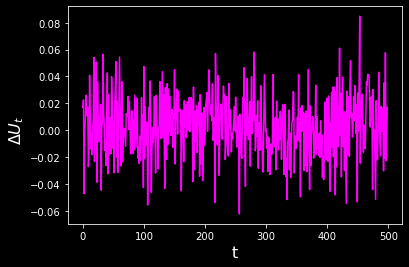

In [11]:
# We can also use pct_change method, for small \delta t 
# this is close to dS by Taylor approximation
# However, this will result in some bias when
# estimating expected shortfall
S_delta_proxy = np.diff(S, axis=1) / S[:, :-1]

# We will plot path #22
plt.plot(S_delta_proxy[22, :])

plt.xlabel('t', fontsize=16)
plt.ylabel('$\Delta U_t$', fontsize=16, rotation=90, ha='right')
#plt.grid(True)

plt.show()

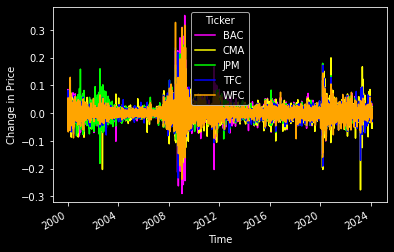

In [12]:
stock_delta=stock_data.pct_change().dropna()

ax = stock_delta.plot.line(xlabel="Time", ylabel="Change in Price")

plt.savefig('stock_delta.png')

### Generate infrequent time series

In [13]:
def infreq(data, T):
    # Step 1: Identify the data dimensionality MxN
    # M corresponds to different paths
    # N corresponds to different observations
    # the observations will get compressed by a factor of T 
    # so that T-day P&L change will show up a 1-day P&L change
    # for the compressed data series
    A = data
    M, N = A.shape

    # Step 2: Generate MxN matrix B with binomial B(1,p) random variables
    # Probability parameter for binomial distribution
    p = 1/T
    B = np.random.binomial(1, p, size=(M, N))

    # Step 3: Calculate matrix C = A*B using component-wise product
    C = np.multiply(A, B)

    # Step 4: Generate matrix D based on conditions
    D = np.zeros_like(C)

    # Iterate over each element of C
    for i in range(M):
        for j in range(N):
            if C[i, j] == 0:  # Condition (i): If C[i, j] is zero, set D[i, j] = C[i, j]
                D[i, j] = C[i, j]
            else:  # Condition (ii): If C[i, j] is non-zero
                # Find the index of the previous non-zero element of C in the same row
                prev_non_zero_idx = np.where(C[i, :j] != 0)[0]
                if len(prev_non_zero_idx) > 0:
                    prev_non_zero_idx = prev_non_zero_idx[-1]  # Get the index of the last previous non-zero element
                    # Cumulative sum of elements of A in the same row until previous non-zero element of C
                    D[i, j] = np.sum(A[i, max(0, prev_non_zero_idx+1):j+1])
                else:
                    # Cumulative sum of elements of A in the same row until the very first element
                    D[i, j] = np.sum(A[i, :j+1])

    return D

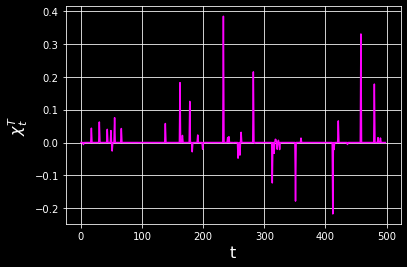

In [14]:
S_delta_inf = infreq(S_delta, 10)

# Plot infrequent P&L
plt.plot(S_delta_inf[22, :])
plt.xlabel('t', fontsize=16)
plt.ylabel('$\chi_t^T$', fontsize=16, rotation=90, ha='right')
plt.grid(True)
plt.show()

# Estimate VaR and ES

In case of normally distributed P&L series, theoretical VaR and ES with 95% confidence level are given by the following formulas.

$
VaR_{\alpha}=\mu+\sigma \Phi^{-1}(\alpha)
$

$
ES_{\alpha}=\mu+\frac{\sigma}{1-\alpha}\phi(\Phi^{-1}(\alpha))
$

In [15]:
def est_var_es(data, alpha):
    
    # Multiline input description
    input_description = """Enter estimator type 
    'par' for parametric
    'nonpar' for non-parametric
    'semipar' for semiparametric: """

    # Get user input for option
    option = input(input_description)

    M, N = data.shape
    var = np.zeros(M)
    cvar = np.zeros(M)
    mean_return = np.zeros(M)
    port_std_dev = np.zeros(M)
    confidence_level = alpha
    z_score = norm.ppf(confidence_level)

    for i in range(M):    
        # Notice that we need to convert negative P&Ls to positive
        returns = -data[i,:]
        if option == 'par':
            # Calculate VaR and CVaR using the parametric method
            mean_return[i] = returns.mean()
            port_std_dev[i] = np.std(returns)
            var[i] = mean_return[i] + port_std_dev[i] * z_score
            cvar[i] = mean_return[i] + port_std_dev[i] * norm.pdf(z_score)/(1-confidence_level)
        elif option == 'nonpar':
            # Calculate VaR and CVaR using the non-parametric method
            var[i] = np.quantile(returns, confidence_level)
            cvar[i] = returns[returns >= var[i]].mean()
        else:
            # Calculate VaR and CVaR using the semi-parametric method
            var[i] = statistics.median(returns) + (np.quantile(returns, confidence_level) - np.quantile(returns, 1-confidence_level))/2
            cvar[i] = statistics.median(returns) + (returns[returns >= var[i]].mean() - returns[returns <= np.quantile(returns, 1-confidence_level)].mean())/2       
            
    return var, cvar

Enter estimator type 
    'par' for parametric
    'nonpar' for non-parametric
    'semipar' for semiparametric: par


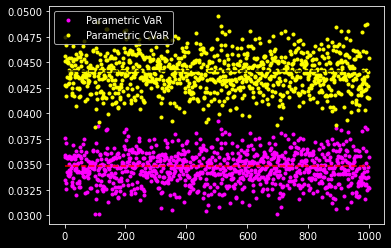

In [16]:
var, cvar = est_var_es(S_delta, .95)

M, N = S_delta.shape
z_score = norm.ppf(.95)
# Notice that -S_delta ~ N(-\delta t, .25 \delta_t)
var_theo = (-1/N + .5 * np.sqrt(1/N) * z_score) * np.ones(M)
cvar_theo = (-1/N + .5 * np.sqrt(1/N) * norm.pdf(z_score)/(1-.95)) * np.ones(M)

plt.plot(var, '.', label='Parametric VaR')
plt.plot(cvar, '.', label='Parametric CVaR')
plt.plot(var_theo, '--', color='red')
plt.plot(cvar_theo, '--', color='black')
plt.legend()
plt.show()

In [17]:
def es_par(data,alpha):
    
    M, N = data.shape
    var = np.zeros(M)
    cvar = np.zeros(M)
    confidence_level = alpha
    z_score = norm.ppf(confidence_level)

    for i in range(M):
        # Calculate VaR and CVaR using the parametric method
        mean_return = np.zeros(M)
        port_std_dev = np.zeros(M)
        # Notice that we need to convert negative P&Ls to positive
        mean_return[i] = -data[i,:].mean()
        port_std_dev[i] = np.std(data[i,:])
        var[i] = mean_return[i] + port_std_dev[i] * z_score
        cvar[i] = mean_return[i] + port_std_dev[i] * norm.pdf(z_score)/(1-confidence_level)
        
    return var, cvar

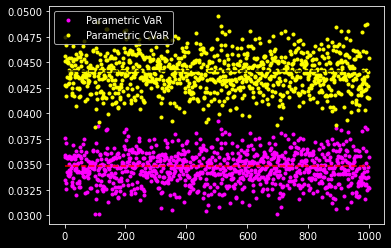

In [18]:
parvar, parcvar = es_par(S_delta, .95)

M, N = S_delta.shape
# Notice that -S_delta ~ N(-\delta t, .25 \delta_t)
var_theo = (-1/N + .5 * np.sqrt(1/N) * z_score) * np.ones(M)
cvar_theo = (-1/N + .5 * np.sqrt(1/N) * norm.pdf(z_score)/(1-.95)) * np.ones(M)

plt.plot(parvar, '.', label='Parametric VaR')
plt.plot(parcvar, '.', label='Parametric CVaR')
plt.plot(var_theo, '--', color='red')
plt.plot(cvar_theo, '--', color='black')
plt.legend()
plt.show()

In [19]:
def es_nonpar(data,alpha):
    
    M, N = data.shape
    var = np.zeros(M)
    cvar = np.zeros(M)
    confidence_level = alpha
    z_score = norm.ppf(confidence_level)
    
    for i in range(M):
        returns = -data[i,:]
        var[i] = np.quantile(returns, confidence_level)
        # Calculate CVAR by computing the average returns below the VAR level
        cvar[i] = returns[returns >= var[i]].mean()
        
    return var, cvar

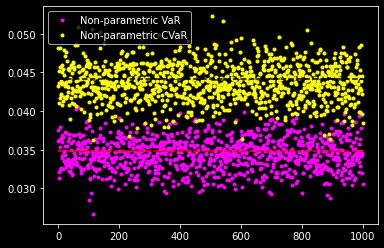

In [20]:
nonvar, noncvar = es_nonpar(S_delta, .95)

M, N = S_delta.shape
# Notice that -S_delta ~ N(-\delta t, .25 \delta_t)
var_theo = (-1/N + .5 * np.sqrt(1/N) * z_score) * np.ones(M)
cvar_theo = (-1/N + .5 * np.sqrt(1/N) * norm.pdf(z_score)/(1-.95)) * np.ones(M)

plt.plot(nonvar, '.', label='Non-parametric VaR')
plt.plot(noncvar, '.', label='Non-parametric CVaR')
plt.plot(var_theo, '--', color='red')
plt.plot(cvar_theo, '--', color='black')
plt.legend()
plt.show()

In [21]:
def es_semipar(data,alpha):
    
    M, N = data.shape
    var = np.zeros(M)
    cvar = np.zeros(M)
    confidence_level = alpha
    z_score = norm.ppf(confidence_level)
    
    for i in range(M):
        returns = -data[i,:]
        var[i] = statistics.median(returns) + np.quantile(returns, confidence_level)/2 - np.quantile(returns, 1-confidence_level)/2

        # Calculate CVAR by computing the average returns below the VAR level
        cvar[i] = statistics.median(returns) + returns[returns >= var[i]].mean()/2 - returns[returns <= np.quantile(returns, 1-confidence_level)].mean()/2
        
    return var, cvar

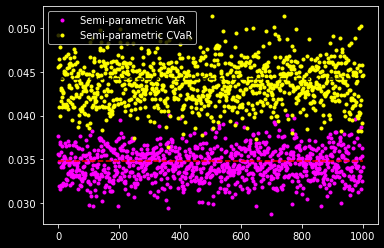

In [22]:
semivar, semicvar = es_semipar(S_delta, .95)

M, N = S_delta.shape
# Notice that -S_delta ~ N(-\delta t, .25 \delta_t)
var_theo = (-1/N + .5 * np.sqrt(1/N) * z_score) * np.ones(M)
cvar_theo = (-1/N + .5 * np.sqrt(1/N) * norm.pdf(z_score)/(1-.95)) * np.ones(M)

plt.plot(semivar, '.', label='Semi-parametric VaR')
plt.plot(semicvar, '.', label='Semi-parametric CVaR')
plt.plot(var_theo, '--', color='red')
plt.plot(cvar_theo, '--', color='black')
plt.legend()
plt.show()

### Non-parametric vs semi-parametric estimation

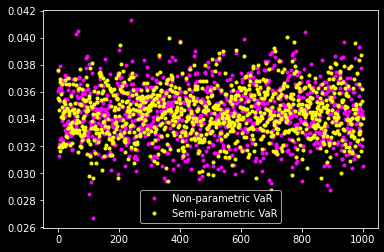

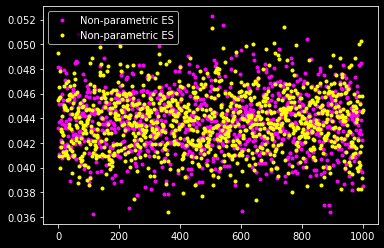

In [23]:
plt.plot(nonvar, '.', label='Non-parametric VaR')
plt.plot(semivar, '.', label='Semi-parametric VaR')
plt.legend()
plt.show()

plt.plot(noncvar, '.', label='Non-parametric ES')
plt.plot(semicvar, '.', label='Non-parametric ES')
plt.legend()
plt.show()

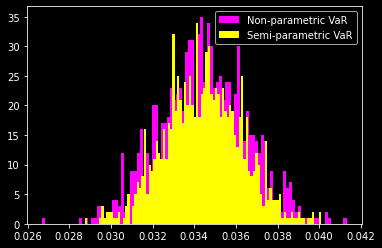

In [24]:
plt.hist(nonvar, bins=100, label='Non-parametric VaR')
plt.hist(semivar, bins=100, label='Semi-parametric VaR')
plt.legend()
plt.show()

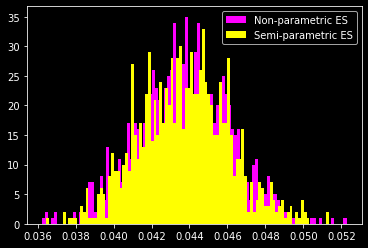

In [25]:
plt.hist(noncvar, bins=100, label='Non-parametric ES')
plt.hist(semicvar, bins=100, label='Semi-parametric ES')
plt.legend()
plt.show()

In [26]:
import seaborn as sns

print("Seaborn version:", sns.__version__)


Seaborn version: 0.13.2


/var/folders/lr/3g4t9zl55xz_y7sh8txcmgy00000gn/T/ipykernel_15597/896025936.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonvar, shade=True, label='Non-parametric VaR')
/var/folders/lr/3g4t9zl55xz_y7sh8txcmgy00000gn/T/ipykernel_15597/896025936.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(semivar, shade=True, label='Semi-parametric VaR')


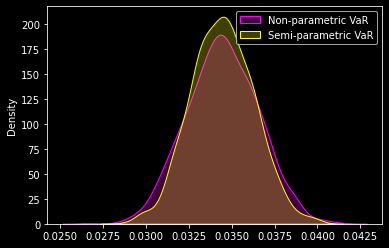

In [27]:
sns.kdeplot(nonvar, shade=True, label='Non-parametric VaR')
sns.kdeplot(semivar, shade=True, label='Semi-parametric VaR')
plt.legend()

/var/folders/lr/3g4t9zl55xz_y7sh8txcmgy00000gn/T/ipykernel_15597/812667667.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(noncvar, shade=True, label='Non-parametric ES')
/var/folders/lr/3g4t9zl55xz_y7sh8txcmgy00000gn/T/ipykernel_15597/812667667.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(semicvar, shade=True, label='Semi-parametric ES')


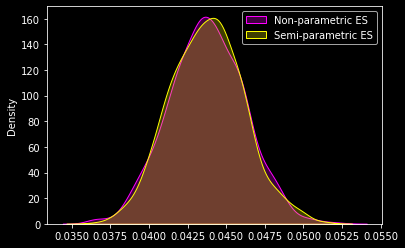

In [28]:
sns.kdeplot(noncvar, shade=True, label='Non-parametric ES')
sns.kdeplot(semicvar, shade=True, label='Semi-parametric ES')
plt.legend()

In [29]:
print('Estimation variances comparison. Semi-parametric estimator outperforms a non-parametric one.')
print('                 ', 'VaR     |', 'ES')
print('Non-parametric   ', round(np.std(nonvar),6), round(np.std(noncvar),6))
print('Semi-parametric  ', round(np.std(semivar),6), round(np.std(semicvar),6))
print('Parametric       ', round(np.std(parvar),6), round(np.std(parcvar),6))

Estimation variances comparison. Semi-parametric estimator outperforms a non-parametric one.
                  VaR     | ES
Non-parametric    0.002084 0.002437
Semi-parametric   0.001836 0.002374
Parametric        0.001519 0.00176


### Run VaR and ES estimation for the equity portfolio

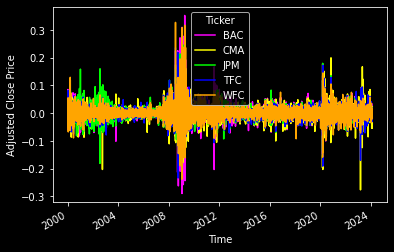

In [30]:
stock_delta=stock_data.pct_change().dropna()
ax = stock_delta.plot.line(xlabel="Time", ylabel="Adjusted Close Price")

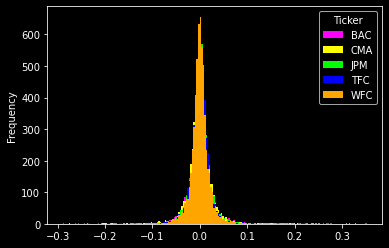

In [31]:
ax = stock_delta.plot(kind='hist', bins=200)

In [32]:
# Convert DataFrame to NumPy array and transpose
data = np.transpose(stock_delta.values)
# Choose estimation period
data_est = data[:,0:1000]
var, cvar = est_var_es(data, .975)

print('---------------------------')
print('Stock', '   VaR', '      ES')
print('---------------------------')
print('BAC   ', round(var[0],6), round(cvar[0],6))
print('CMA   ', round(var[1],6), round(cvar[1],6))
print('JPM   ', round(var[2],6), round(cvar[2],6))
print('TFC   ', round(var[3],6), round(cvar[3],6))
print('WFC   ', round(var[4],6), round(cvar[4],6))

Enter estimator type 
    'par' for parametric
    'nonpar' for non-parametric
    'semipar' for semiparametric: par
---------------------------
Stock    VaR       ES
---------------------------
BAC    0.054214 0.064769
CMA    0.050031 0.059768
JPM    0.046022 0.055011
TFC    0.042924 0.051284
WFC    0.046702 0.05581


In [33]:
stock_delta.head()

Ticker,BAC,CMA,JPM,TFC,WFC
Date,,,,,
2000-01-04,-0.059355,-0.041666,-0.021942,-0.029055,-0.049520
2000-01-05,0.010974,-0.002899,-0.006172,0.012468,-0.010085
2000-01-06,0.085482,0.029070,0.014197,0.046798,0.044143
2000-01-07,-0.026250,-0.001412,0.018374,0.007058,0.017886
2000-01-10,-0.034660,-0.032532,-0.017183,-0.025701,-0.031949


In [34]:
data[0:4,0:5]

array([[-0.05935471,  0.0109742 ,  0.08548193, -0.02625045, -0.03465988],
       [-0.04166646, -0.00289896,  0.02906972, -0.00141192, -0.03253195],
       [-0.02194227, -0.00617226,  0.0141967 ,  0.01837363, -0.01718311],
       [-0.02905523,  0.0124682 ,  0.04679818,  0.00705845, -0.02570057]])

### Backtesting

In [35]:
# A quick note on the data input
# it is assumed that the P&Ls corresponding
# to one simulation/stock are recorded in a row.
# Notice, that var has to be defined
# to be able to run this function

def bt_traffic(data_perf,alpha):
    # data_perf is the data for backtest
    M, N = data_perf.shape
    total = np.zeros(M)
    count = np.zeros(M)
    for i in range(M):
        returns = data_perf[i,:]       
        sorted_returns = np.sort(returns)
        for j in range(N):
            if sorted_returns[j] + var[i] <= 0:
                total[i] += sorted_returns[j]
                count[i] += 1
                
    return count, total

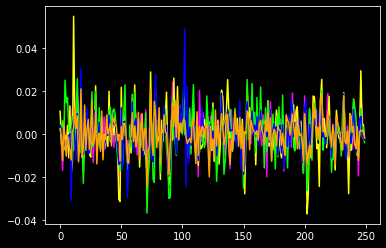

In [36]:
# It is possible to have 0 elements 
# exceeding VaR
data_perf = data[:,1001:1251]
plt.plot(np.transpose(data_perf[:,:]))

In [37]:
bt_traffic(data_perf,97.5)
#plt.plot(total, 'o')

(array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]))

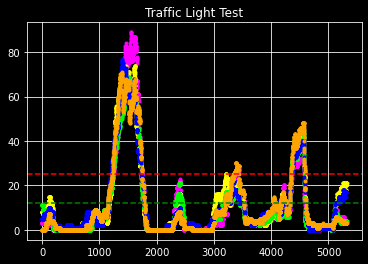

In [38]:
# lookback is the VaR/ES lookback period
# W is the sliding backtesting window 
# intervals is the total number of backtesting intervals
M, N = data.shape
lookback = 500
W = 250
# We implicitly assume that N >= lookback + W
# this means we have enough data for estimation and
# at least one backtest

intervals = N - lookback - (W - 1)

# Define variables for recording
# backtesting results
backtest_count = []
backtest_total = []
backtest_cvar = []
# Perform backtesting in a loop
for k in range(intervals):
    data_est = data[:,k:(lookback+k-1)]
    var, cvar = es_nonpar(data_est, .975)
    data_perf = data[:,(lookback+k):(lookback+k+W-1)]
    count, total = bt_traffic(data_perf,0.975)
    backtest_count.append(count)
    backtest_total.append(total)
    backtest_cvar.append(cvar)

backtest_count = np.array(backtest_count)
backtest_total = np.array(backtest_total)
backtest_cvar = np.array(backtest_cvar)

plt.plot(backtest_count, '.')
plt.grid('True')
plt.axhline(y=12, color='g', linestyle='--')
plt.axhline(y=25, color='r', linestyle='--')
plt.title('Traffic Light Test')

plt.savefig('traffic_light.png')

plt.show()

/var/folders/lr/3g4t9zl55xz_y7sh8txcmgy00000gn/T/ipykernel_15597/2237420525.py:2: RuntimeWarning: invalid value encountered in divide
  back_ascond = backtest_total / backtest_count - backtest_cvar


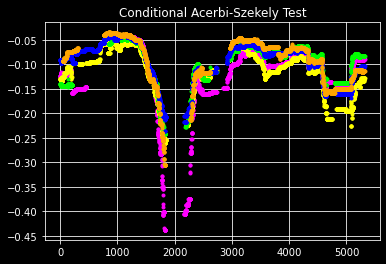

In [39]:
# back_ascond(data,𝛼)  - backtests ES using conditional Acerbi-Szekely test
back_ascond = backtest_total / backtest_count - backtest_cvar
plt.plot(back_ascond, '.')
plt.grid('True')
plt.title('Conditional Acerbi-Szekely Test')
plt.show()

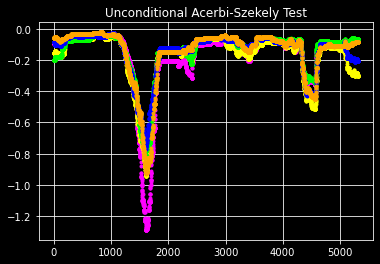

In [40]:
# back_asuncond(data,𝛼)  - backtests ES using unconditional Acerbi-Szekely test
back_asuncond = backtest_total / (250*(1-.975)) - backtest_cvar
plt.plot(back_asuncond, '.')
plt.grid('True')
plt.title('Unconditional Acerbi-Szekely Test')
plt.show()

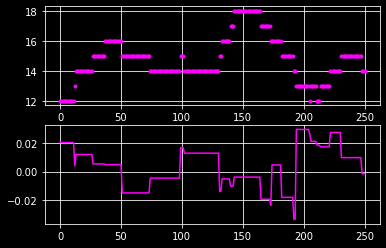

In [41]:
# Normal distribution for illustration
actual_losses = np.random.normal(loc=0, scale=1, size=1000)  

# Estimated ES at a 95% confidence level
estimated_var = np.percentile(actual_losses[:500], 97.5)
est_losses = actual_losses[:500]
estimated_es = -np.mean(est_losses[est_losses <= -estimated_var])

count=np.zeros(1000-500-250+1)
total=np.zeros(1000-500-250+1)
for i in range(1000-500-250+1):
    count[i] = np.sum(actual_losses[500+i:500+i+250-1] <= -estimated_var)
    backtest_losses = actual_losses[500+i:500+i+250-1]
    total[i] = np.mean(backtest_losses[backtest_losses <= -estimated_var])+estimated_es

plt.subplot(211)
plt.plot(count, '.')
plt.grid('True')
plt.subplot(212)
plt.plot(total)
plt.grid('True')
plt.show()